# 1D Schrodinger n-qubit

In [96]:
import matplotlib.pyplot as plt
import math
import numpy as np
from qiskit.circuit.library import NormalDistribution
from math import pi
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram

In [97]:
def QFT(qc,nqb):
    for i in range(int(nqb/2)):
        qc.swap(i+1,nqb-i)
    for i in range(nqb):
        qc.h(i+1)
        for j in range(nqb - 1 - i):
            qc.cp(pi/(2**(j+1)), i+2+j, i+1)
                
def QFT_Inv(qc,nqb):
    for i in reversed(range(nqb)):
        for j in reversed(range(nqb - 1 - i)):
            qc.cp(-pi/(2**(j+1)), i+2+j, i+1)
        qc.h(i+1)
    for i in range(int(nqb/2)):
        qc.swap(i+1,nqb-i)
                
def Time_Evolution(qc,nqb,phi):
    for i in range (nqb):
        qc.p(phi/(2**(i+nqb-3)), nqb-i)
    for i in range (nqb):
        for j in range (i+1,nqb):
            qc.cx(nqb-j, 0)
            qc.cx(nqb-i, 0)
            qc.p(phi* (2**(2-i-j)), 0) #2-i-j or 4?
            qc.cx(nqb-i, 0)
            qc.cx(nqb-j, 0)
    
def schrod_init(nqb,init_type): 
    
    # init_type = 'gaussian', 'uniform', 'delta', 
    x = np.linspace(-2,2, num=2**nqb)

    if init_type == 'gaussian':
    #Preparing the Gaussian-shaped histogram that will be used in the initialisation
        Norm_wf = (1/(np.sqrt(2*np.pi)*2*0.4)*np.exp(-(0.5*x**2)/(2*0.016)))
        Norm_Const = np.sqrt(np.sum(np.abs(Norm_wf**2)))
        wFunction = (Norm_wf)/(Norm_Const)
    
    elif init_type == 'uniform':
        
        wFunction = (x/x)*np.sqrt(1/2**nqb)
    
    elif init_type == 'delta':
        
        wFunction = x/x
        for i in range(len(wFunction)):
            if i == len(wFunction)/2:
                wFunction[i,] = 1
            else:
                wFunction[i,] = 0
    
    elif init_type == 'step':
        
        step1 = (2**nqb)/4
        step2 = (2**nqb)/2
        print(step2)
        
        wFunction = (x/x)
        for i in range(len(wFunction)):
            if i < step1:
                wFunction[i,] = 0
            elif i >= step1 and i < (step1+step2):
                wFunction[i,] = 1/np.sqrt(step2)
            else:
                wFunction[i,] = 0
        print(wFunction)
            
    
    return x, wFunction

In [98]:
def SchroedingerCircuit(nqb, init_type, time_step, tot_time_steps, type_potential):
    
    phi = time_step

    q = QuantumRegister(nqb + 1)
    c = ClassicalRegister(nqb)
    qc1 = QuantumCircuit(q)
    qc2 = QuantumCircuit(q)
    
    
    x, waveFunction = schrod_init(nqb,init_type)
    l = 0
    a = []
    init = []
    
    
    #for l in range(tot_time_steps):    
    for i in range(nqb): 
        init += [q[i+1]]
        a.append(i)

    qc2.initialize(waveFunction, init) 
    #qc.potential(V*phi,nqb)
    qc1.barrier()
    QFT(qc1,nqb)
    qc1.x(nqb)    
    qc1.barrier()
    Time_Evolution(qc1,nqb,phi)
    qc1.x(nqb)   
    qc1.barrier()
    QFT_Inv(qc1,nqb)
    qc1.barrier()

    for i in range(tot_time_steps):
        qc2.append(qc1, q)  
    
    qc2.measure_all()
    
    return qc2

# Simulation on QASM

### 1 Time - Step

2.0
[0.         0.70710678 0.70710678 0.        ]


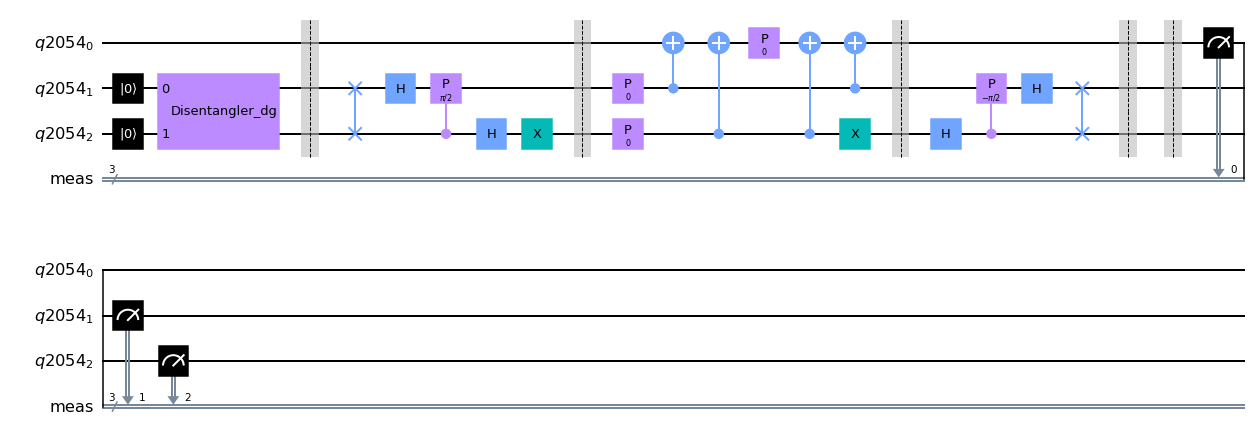

In [99]:
qc = SchroedingerCircuit(2, 'step', 0.0, 1, 0)

backend = BasicAer.get_backend('qasm_simulator')
shots = 8192
results = execute(qc, backend=backend, shots=shots).result()
results_counts = results.get_counts()
qc.decompose().draw('mpl')

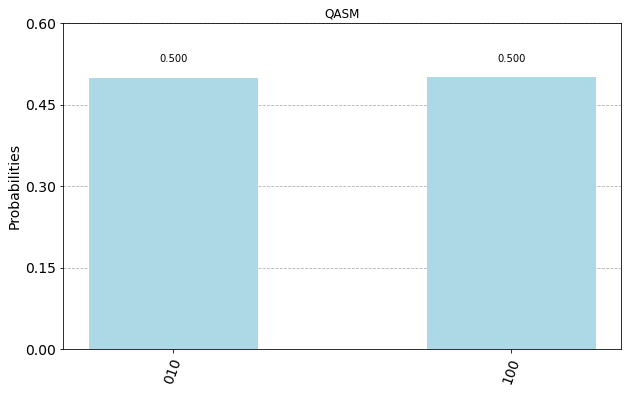

In [100]:
plot_histogram(results_counts, title = "QASM", figsize = [10,6], color = 'lightblue')

### Arbitrary Time Steps

In [101]:
# Set time steps 
time_steps = 5

for l in range(time_steps):
    
    qc = SchroedingerCircuit(2, 'step', pi/4, l, 0)

    backend = BasicAer.get_backend('qasm_simulator')
    shots = 8192
    results = execute(qc, backend=backend, shots=shots).result()
    results_counts = results.get_counts()
    
    #print(qc.decompose())


    plot_histogram(results_counts, title = "Test", figsize = [10,7]).savefig(str(l) +'.png')

2.0
[0.         0.70710678 0.70710678 0.        ]
2.0
[0.         0.70710678 0.70710678 0.        ]
2.0
[0.         0.70710678 0.70710678 0.        ]
2.0
[0.         0.70710678 0.70710678 0.        ]
2.0
[0.         0.70710678 0.70710678 0.        ]


# Simulation on Fake Athens

In [102]:
from qiskit.test.mock import FakeYorktown, FakeAthens, FakeTokyo
import qiskit.tools.jupyter
from qiskit.compiler import transpile
from itertools import permutations


backend1 = FakeAthens()
backend1

<FakeAthens('fake_athens') from None()>

## Optimal Layer Search

In [103]:
#l = list(permutations(range(1, 4)))
#type(l[1][0])

In [104]:
# def optimization_layout(qc, nqb, backend):
    
#     i = 0
#     depth = []
#     l = list(permutations(range(0, 20-nqb)))
#     while i < len(l):
#         layout = []
#         for j in l[i]:
#             layout.append(l[i][j])
    
#         t_qc = transpile(qc, backend, initial_layout = layout, optimization_level = 3)  
#         depth.append(t_qc.depth())
#         index_min = np.argmin(depth)
#         i +=1
    
#     optimized = []
#     for j in range(nqb): a.append(index_min + j)
    
#     return optimized
    

In [105]:
#layout = optimization_layout(qc,3, backend1)
layout = [1,2,3]

## Simulation

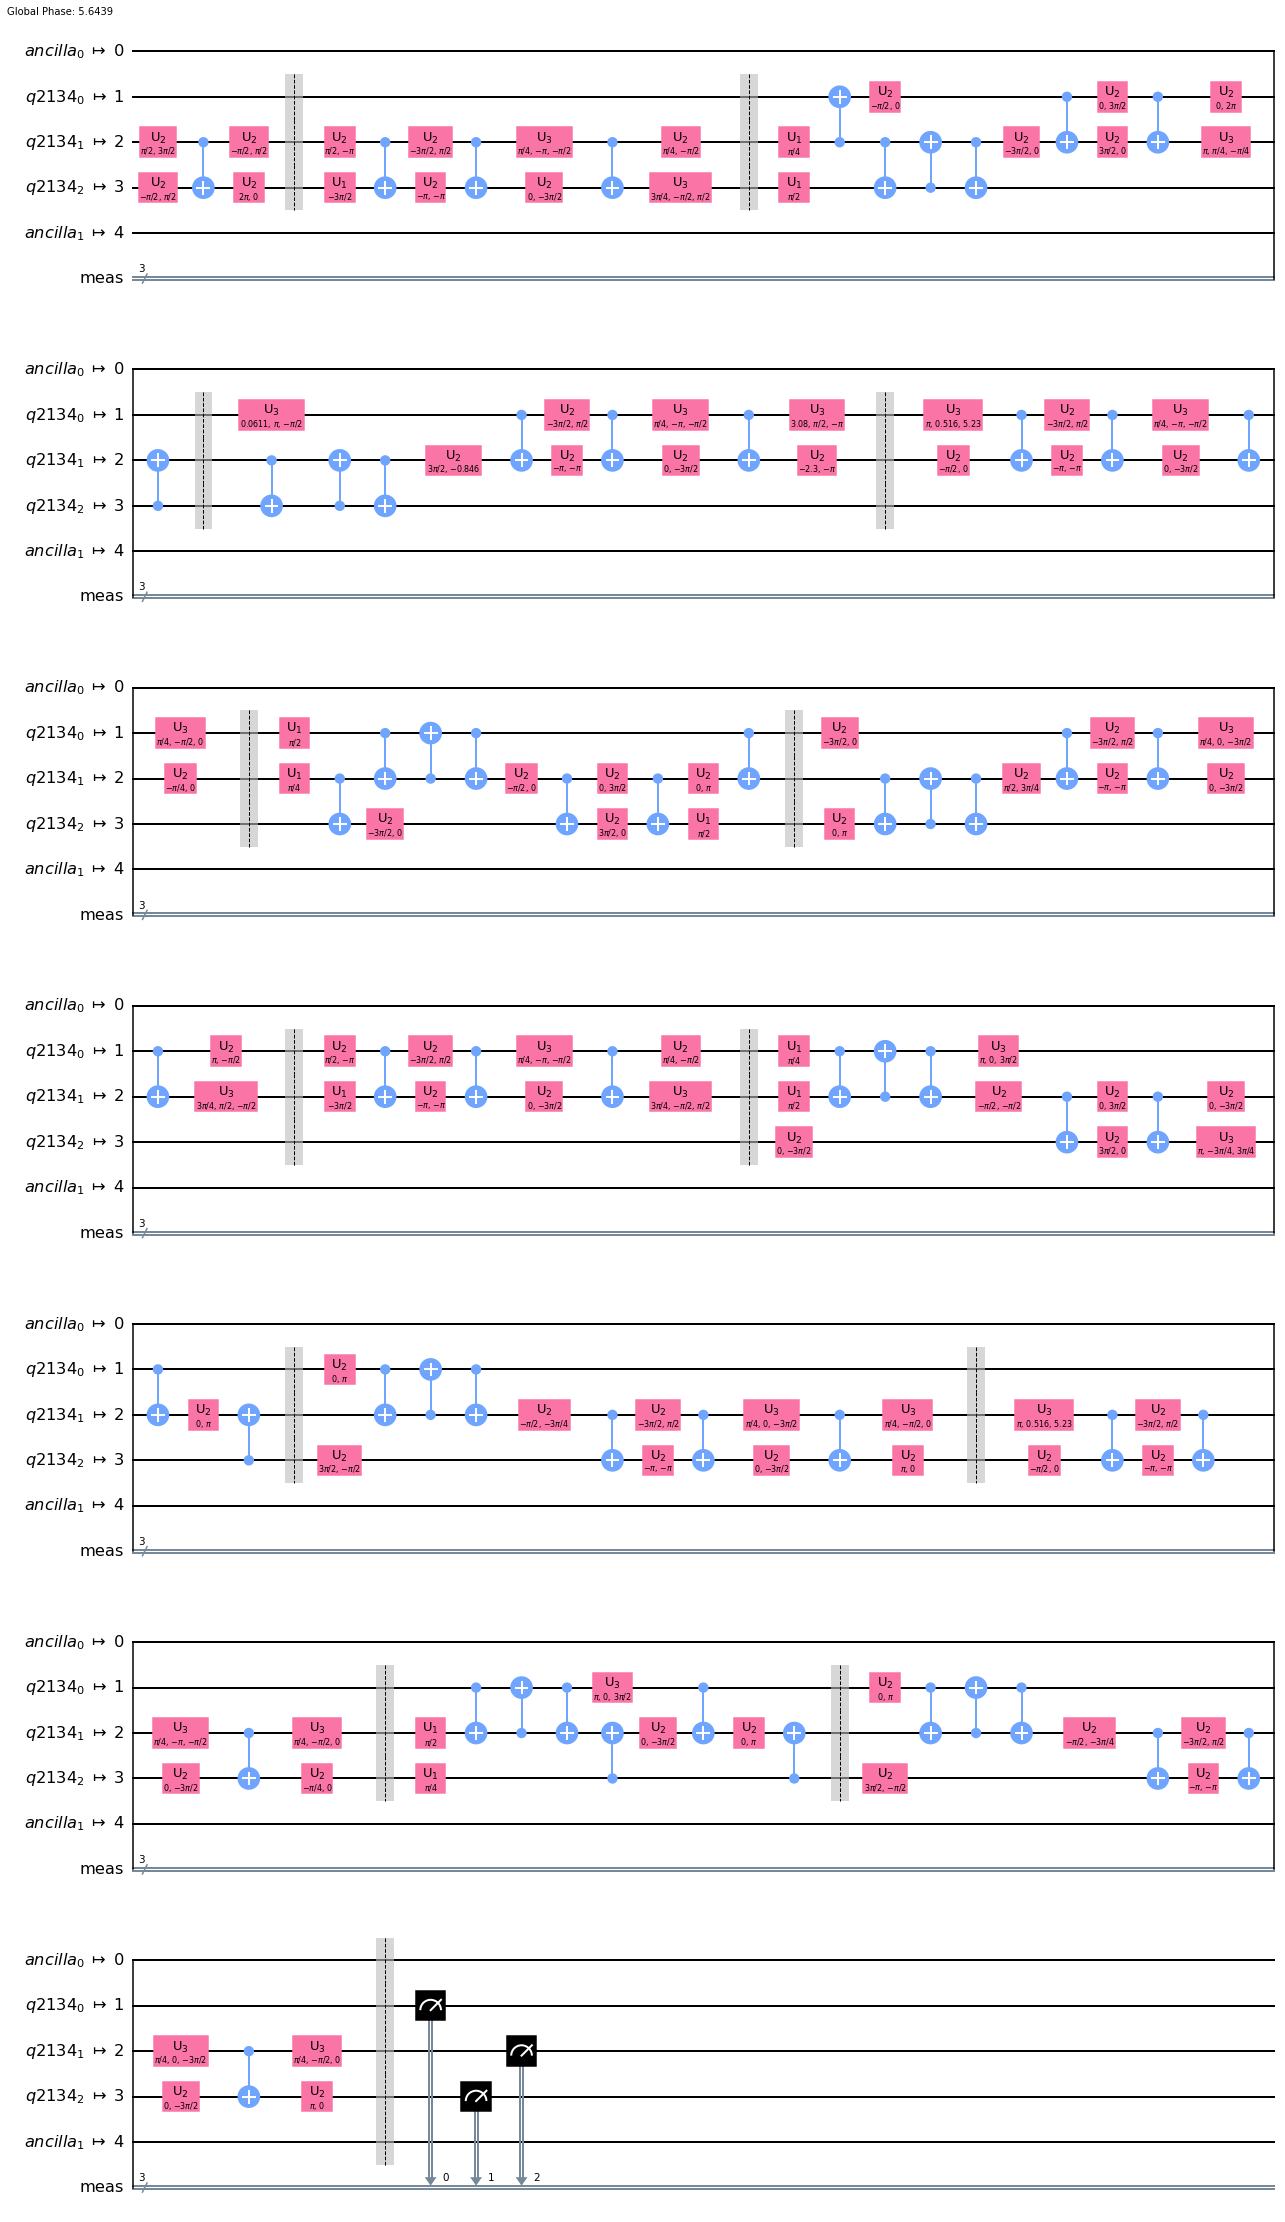

In [106]:
t_qc = transpile(qc, backend1, initial_layout = layout, optimization_level = 3)  
t_qc.draw('mpl')

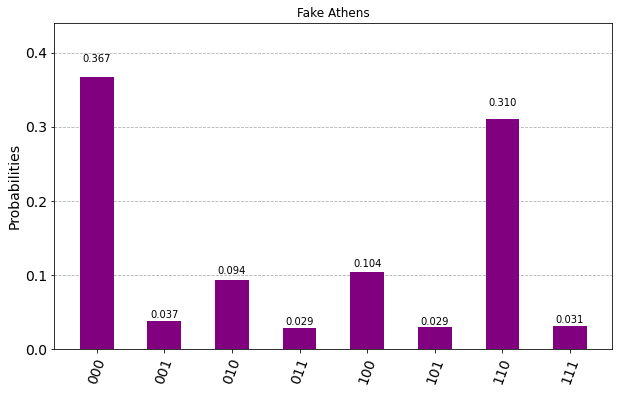

In [107]:
job1 = execute(t_qc, backend1, shots=8192)
results = job1.result()
noisy_counts = job1.result().get_counts()
plot_histogram(noisy_counts, title = 'Fake Athens', figsize = [10,6], color = 'purple')

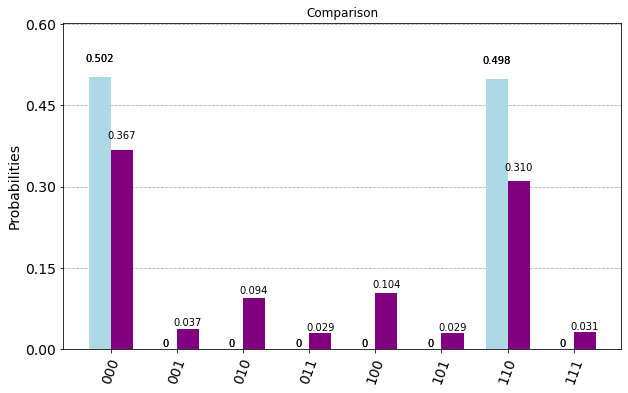

In [108]:
plot_histogram([results_counts, noisy_counts], title = "Comparison",  figsize = [10,6], color = ['lightblue', 'purple'])